In [1]:
!pip install tqdm

In [2]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [3]:
df = pd.read_csv('./dataset.csv')

df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [5]:
n_User_id = len(set(df.User_ID))

In [6]:
total_purchase = df.groupby(by=['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']).agg({'Purchase':sum})
total_purchase = total_purchase.reset_index(level=['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status'])
total_purchase.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase
User_ID,,,,,,,
1000001,F,0-17,10,A,2,0,333481
1000002,M,55+,16,C,4+,0,810353
1000003,M,26-35,15,A,3,0,341635
1000004,M,46-50,7,B,2,1,205987
1000005,M,26-35,20,A,1,1,821001


In [7]:
pc_count = pd.DataFrame( [[0]*18] * n_User_id, columns=list(range(1,19)), index=set(df.User_ID))

def def_count(v):
    def count(n):
        return sum(n==v)
    return count

agg_f = { v:def_count(v) for v in range(1,19)}

pc_count_intermediate = df.groupby('User_ID').agg({f'Product_Category_{i}': agg_f for i in range(1,4)})

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [8]:
for index, row in tqdm(pc_count_intermediate.iterrows(), total=len(pc_count_intermediate)):
    s = row.loc['Product_Category_1'] + row.loc['Product_Category_2'] + row.loc['Product_Category_3']
    pc_count.loc[index,:] = s

In [9]:
pc_count.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1000001,4.0,3.0,11.0,13.0,5.0,2.0,0.0,13.0,2.0,0.0,0.0,8.0,0.0,3.0,1.0,2.0,2.0,0.0
1000002,31.0,9.0,0.0,0.0,15.0,9.0,0.0,46.0,1.0,1.0,2.0,0.0,3.0,10.0,7.0,14.0,7.0,1.0
1000003,15.0,15.0,1.0,1.0,15.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0,2.0,0.0,4.0
1000004,13.0,4.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,5.0,3.0,1.0,0.0
1000005,18.0,5.0,2.0,4.0,26.0,9.0,5.0,57.0,0.0,1.0,5.0,2.0,4.0,13.0,6.0,21.0,2.0,0.0


In [10]:
pc_count_L2 = pc_count.div(np.sqrt(pc_count.pow(2).sum(axis=1)), axis=0)

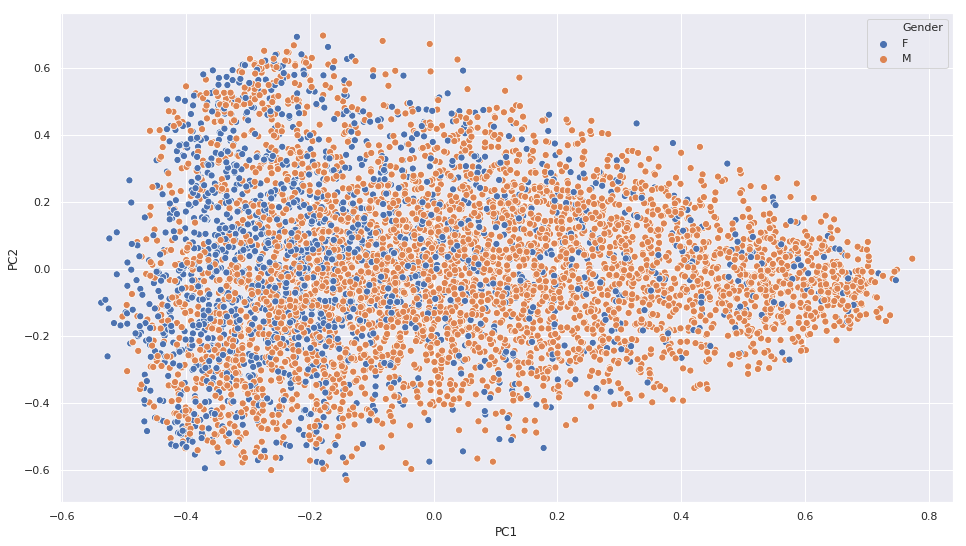

AttributeError: 'Int64Index' object has no attribute 'labels'

In [76]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(pc_count_L2)
pca = pd.DataFrame(pca, index = pc_count_L2.index
             , columns = ['PC1', 'PC2'])

plt.figure(figsize=(16, 9))
sns.scatterplot(x='PC1', y='PC2', hue=total_purchase['Gender'], s=50, data=pca)
plt.show()
style=total_purchase.index.labels[1]

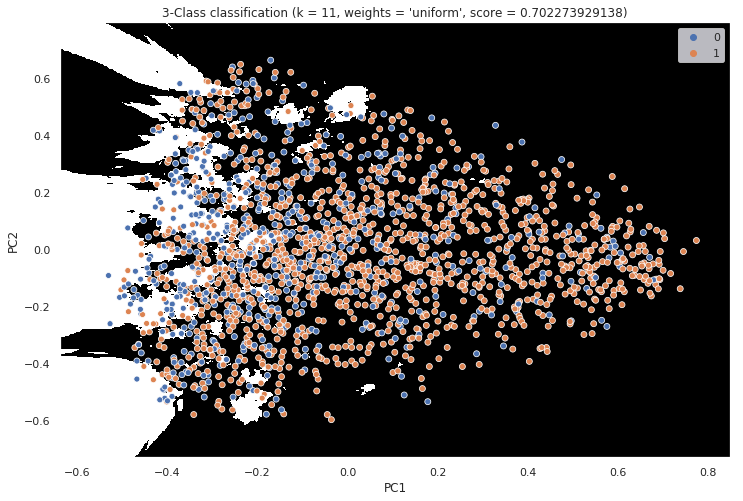

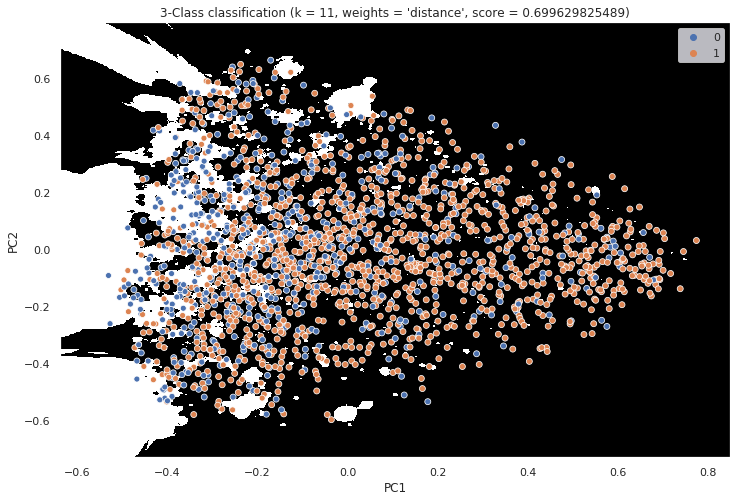

In [98]:
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

n_neighbors=13

def map_f(e):
    if e == 'F':
        return 0
    else:
        return 1

def shuffle(df, n=1, axis=0):     
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df


n_train = 4000

X, y = pca.iloc[:n_train,:],  [map_f(e) for e in total_purchase['Gender'][:n_train]]
X_test, y_test = pca.iloc[n_train:,:],  [map_f(e) for e in total_purchase['Gender'][n_train:]]

h = .0025  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFFFFFFF', '#00000000'])
cmap_bold = ListedColormap(['#FFFF00', '#00FFFF', '#0000FF'])

for n_neighbors in range(11,13, 2):
    for weights in ['uniform', 'distance']:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(X, y)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
        y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        
        #Z[:-1] = abs(Z[:-1] - Z[1:])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(figsize=(12,8))

        # Plot also the training points
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=1)
        sns.scatterplot(X_test.iloc[:, 0], X_test.iloc[:, 1], hue=y_test)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        r = clf.score(X_test, y_test)
        plt.title("3-Class classification (k = %i, weights = '%s', score = %s)"
                  % (n_neighbors, weights, r))

plt.show()

In [99]:
def map_f(e):
    if e == 'F':
        return 0
    else:
        return 1

n_train = 4000

X, y = pc_count_L2.iloc[:n_train,:],  [map_f(e) for e in total_purchase['Gender'][:n_train]]
X_test, y_test = pc_count_L2.iloc[n_train:,:],  [map_f(e) for e in total_purchase['Gender'][n_train:]]

for n_neighbors in range(1,23, 2):
    for weights in ['uniform', 'distance']:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(X, y)
        r = clf.score(X_test, y_test)
        print("3-Class classification (k = %i, weights = '%s', score = %s)"
                  % (n_neighbors, weights, r))

3-Class classification (k = 1, weights = 'uniform', score = 0.696456901111)
3-Class classification (k = 1, weights = 'distance', score = 0.696456901111)
3-Class classification (k = 3, weights = 'uniform', score = 0.734531993654)
3-Class classification (k = 3, weights = 'distance', score = 0.734003172924)
3-Class classification (k = 5, weights = 'uniform', score = 0.736647276573)
3-Class classification (k = 5, weights = 'distance', score = 0.736118455843)
3-Class classification (k = 7, weights = 'uniform', score = 0.746166049709)
3-Class classification (k = 7, weights = 'distance', score = 0.74510840825)
3-Class classification (k = 9, weights = 'uniform', score = 0.748281332628)
3-Class classification (k = 9, weights = 'distance', score = 0.746694870439)
3-Class classification (k = 11, weights = 'uniform', score = 0.746694870439)
3-Class classification (k = 11, weights = 'distance', score = 0.74510840825)
3-Class classification (k = 13, weights = 'uniform', score = 0.747223691169)
3-Cla

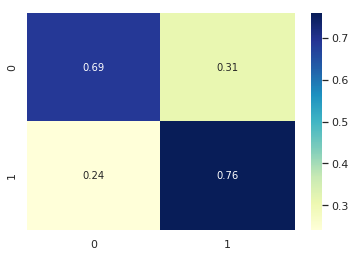

In [67]:
from sklearn.metrics import confusion_matrix

n_neighbors = 9
weights = 'uniform'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, y)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_pred, y_test)
risk = (conf.transpose() / conf.sum(axis=1)).transpose()
sns.heatmap(risk, annot=True, cmap="YlGnBu")
plt.show()

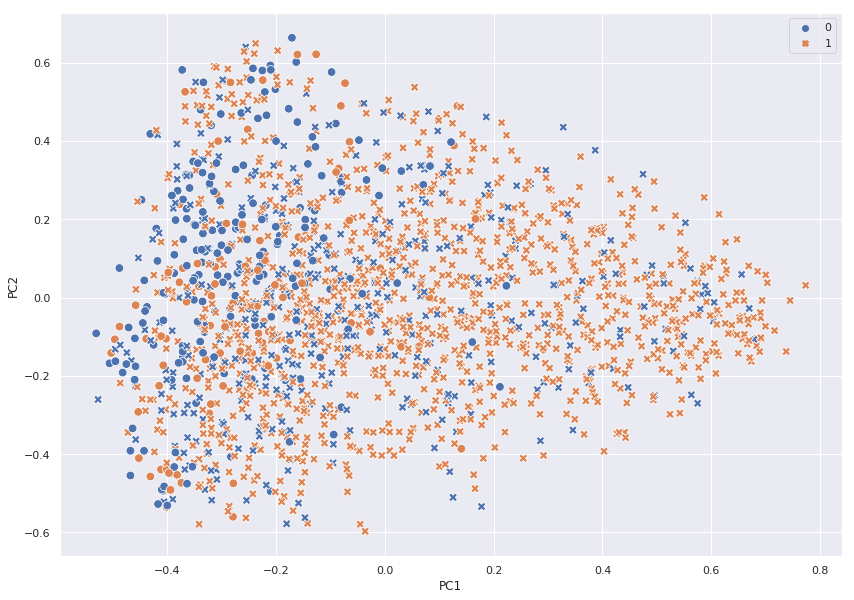

In [116]:
pca_X_test = pca.iloc[n_train:,:]
plt.figure(figsize=(14,10))
data = {
    'x' : pca_X_test['PC1'],
    'y' : pca_X_test['PC2'],
    'Gender' : y_test,
    'Pred' : y_pred
}
sns.scatterplot(x='x', y='y', s=75, data=data, legend='full', hue='Gender', style='Pred')
plt.show()